In [1]:
from model.unet import *
from utils.metrics import *
from utils.losses import *
from utils.training import save_checkpoint, load_checkpoint

import os
import pandas as pd
import warnings
import numpy as np
import torch
from skimage import io
from rasterio.features import rasterize
from shapely.ops import unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import albumentations as A
from torch.optim import lr_scheduler
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.cuda import amp
from time import time
import glob
import pickle
from pyproj import Transformer
from shapely.ops import transform as shapely_transform
from rasterio.transform import from_origin
from dotenv import load_dotenv
from datetime import datetime

from pathlib import Path
from sklearn.metrics import jaccard_score, classification_report, confusion_matrix

from PIL import Image, ImageDraw, ImageEnhance
import skimage.draw as sk

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore")

/Users/ix20088/.pyenv/versions/3.8.20/envs/forestchat-env/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
%load_ext dotenv
%dotenv -o

In [3]:
BASE_DIR = os.environ.get("BASE_DIR", "CAM-ForestNetDataset")
SUB_DIR = os.environ.get("SUB_DIR", "Landsat-Detailed-Timeseries")
PIXEL_RESOLUTION = 4.77 if 'Planet' in SUB_DIR else 15
MODEL_NAME = os.environ.get("MODEL_NAME", "UNET")
TIMESERIES_LENGTH =int(os.environ.get("TIMESERIES_LENGTH", 5))
EXAMPLES_FOLDER = os.environ.get("EXAMPLES_FOLDER", "examples")
LABEL_SCHEME = SUB_DIR.split('-')[-1]

train_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/train.csv')
val_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/val.csv')
test_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/test.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Oil palm plantation,Oil palm plantation,3.91875,9.896375,2015,examples/9.896374999999999_3.9187499999999997_0
1,Oil palm plantation,Oil palm plantation,3.91875,9.896375,2015,examples/9.896374999999999_3.9187499999999997_1
2,Oil palm plantation,Oil palm plantation,3.91875,9.896375,2015,examples/9.896374999999999_3.9187499999999997_2
3,Oil palm plantation,Oil palm plantation,3.91875,9.896375,2015,examples/9.896374999999999_3.9187499999999997_3
4,Oil palm plantation,Oil palm plantation,3.91875,9.896375,2015,examples/9.896374999999999_3.9187499999999997_4


In [4]:
example_row_number = 964
row = train_df.iloc[example_row_number]
print(row)

folder = row["example_path"].split("/")[1]

label                                          Selective logging
merged_label                                   Selective logging
latitude                                                2.391736
longitude                                              10.454208
year                                                        2017
example_path    examples/10.454208333333334_2.3917361111111104_4
Name: 964, dtype: object


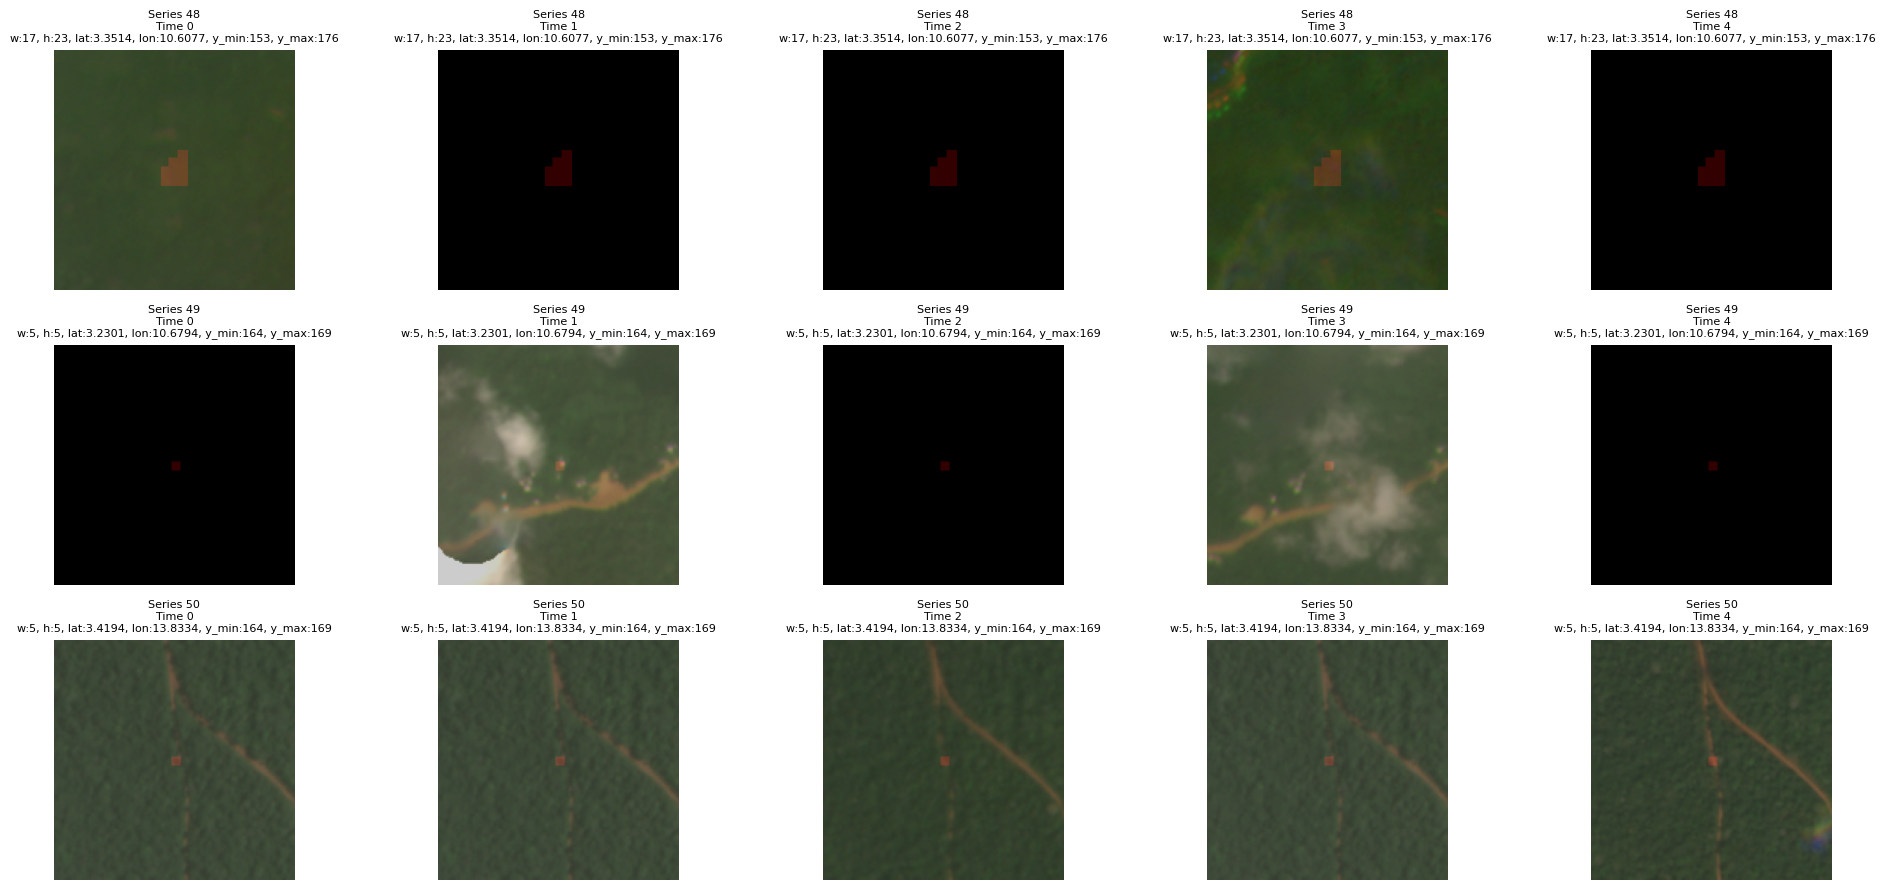

In [59]:
from PIL import Image, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import glob
import numpy as np
import re

def visualise_batch(start_idx=0, batch_size=16):
    df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/train.csv')
    rows = df.iloc[start_idx:start_idx+batch_size]

    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    axs = axs.flatten()

    for ax, (_, row) in zip(axs, rows.iterrows()):
        folder = row['example_path'].split('/')[1]
        img_path = glob.glob(f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/{folder}/images/visible/*.png')[0]
        shape_path = f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/{folder}/forest_loss_region.pkl'

        try:
            img = Image.open(img_path).convert("RGB")
            img = ImageEnhance.Brightness(img).enhance(2.0)
            width = height = 332
            mask = Image.new('RGB', (width, height), (0, 0, 0))
            draw = ImageDraw.Draw(mask)

            with open(shape_path, 'rb') as f:
                shape = pickle.load(f)

            lon_c = shape.centroid.xy[0][0]
            lat_c = shape.centroid.xy[1][0]

            # Meters per degree approximation
            m_per_deg_lat = 111132.954 - 559.822 * np.cos(2 * lat_c) + 1.175 * np.cos(4 * lat_c) - 0.0023 * np.cos(6 * lat_c)
            m_per_deg_lon = 111132.954 * np.cos(lat_c) - 93.5 * np.cos(3 * lat_c) + 0.118 * np.cos(5 * lat_c)

            deg_lat = (width * PIXEL_RESOLUTION * 0.5) / m_per_deg_lat
            deg_lon = (height * PIXEL_RESOLUTION * 0.5) / m_per_deg_lon

            div_lon = 2 * deg_lon / width
            div_lat = 2 * deg_lat / height

            if shape.geom_type == "Polygon":
                coords = []
                for lon, lat in shape.exterior.coords:
                    x = width - int((lon - lon_c + deg_lon) / div_lon)
                    y = height - int((lat - lat_c + deg_lat) / div_lat)
                    coords.append((x, y))

                draw.polygon([tuple(coord) for coord in coords],
                            outline='red', fill='red')
            else:
                for poly in shape:
                    coords = []
                    for lon, lat in shape.exterior.coords:
                        x = width - int((lon - lon_c + deg_lon) / div_lon)
                        y = height - int((lat - lat_c + deg_lat) / div_lat)
                        coords.append((x, y))

                    draw.polygon([tuple(coord) for coord in coords],
                                outline='red', fill='red')

            overlay = Image.blend(img, mask, alpha=0.4)

            crop_start = (width - 160) // 2
            crop_end = crop_start + 160
            cropped_overlay = overlay.crop((crop_start, crop_start, crop_end, crop_end))

            # Diagnostic annotations
            bbox_x = [x for x, y in coords]
            bbox_y = [y for x, y in coords]
            if bbox_x and bbox_y:
                x_min, x_max = min(bbox_x), max(bbox_x)
                y_min, y_max = min(bbox_y), max(bbox_y)
                bbox_w = x_max - x_min
                bbox_h = y_max - y_min
                annotation = f"w:{bbox_w}, h:{bbox_h}, lat:{lat_c:.4f}, lon:{lon_c:.4f}, y_min:{y_min}, y_max:{y_max}"
            else:
                annotation = "No valid coords"

            ax.imshow(cropped_overlay)
            ax.axis('off')
            ax.set_title(f"Idx {row.name}: {annotation}", fontsize=9)

        except Exception as e:
            ax.text(0.5, 0.5, f"Error\n{e}", ha='center', va='center', wrap=True)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def visualise_timeseries_batch(start_idx=0, num_series=3, timestamps=5):
    """
    Visualize complete time series starting from specified index.
    
    Parameters:
    - start_idx: Starting index of time series (group of timestamps)
    - num_series: Number of complete time series to display
    - timestamps: Number of timestamps per series to show (default 5)
    """
    df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/train.csv')
    
    # Extract base coordinates without timestamp
    df['series_id'] = df['example_path'].apply(lambda x: re.sub(r'_\d+$', '', x.split('/')[-1]))
    
    # Get unique series in order
    unique_series = df['series_id'].unique()[start_idx:start_idx+num_series]
    
    fig, axs = plt.subplots(num_series, timestamps, figsize=(20, 3*num_series))
    if num_series == 1:
        axs = axs.reshape(1, -1)  # Ensure 2D array for single series
    
    for series_idx, series_id in enumerate(unique_series):
        # Get all timestamps for this series, sorted
        series_df = df[df['series_id'] == series_id] \
                   .sort_values('example_path') \
                   .head(timestamps)
        
        for time_idx, (_, row) in enumerate(series_df.iterrows()):
            ax = axs[series_idx, time_idx]
            folder = row['example_path'].split('/')[-1]
            
            try:
                # Load image and mask
                img_path = glob.glob(f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/{folder}/images/visible/*.png')[0]
                shape_path = f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/{folder}/forest_loss_region.pkl'
                
                # Process image
                img = Image.open(img_path).convert("RGB")
                img = ImageEnhance.Brightness(img).enhance(1.5)
                width = height = 332
                mask = Image.new('RGB', (width, height), (0, 0, 0))
                draw = ImageDraw.Draw(mask)
                
                # Process shapefile
                with open(shape_path, 'rb') as f:
                    shape = pickle.load(f)
                
                # Coordinate transformation (your original code)
                lon_c = shape.centroid.xy[0][0]
                lat_c = shape.centroid.xy[1][0]
                m_per_deg_lat = 111132.954 - 559.822 * np.cos(2 * lat_c) + 1.175 * np.cos(4 * lat_c) - 0.0023 * np.cos(6 * lat_c)
                m_per_deg_lon = 111132.954 * np.cos(lat_c) - 93.5 * np.cos(3 * lat_c) + 0.118 * np.cos(5 * lat_c)
                deg_lat = (width * PIXEL_RESOLUTION * 0.5) / m_per_deg_lat
                deg_lon = (height * PIXEL_RESOLUTION * 0.5) / m_per_deg_lon
                div_lon = 2 * deg_lon / width
                div_lat = 2 * deg_lat / height
                
                # Draw polygon (your original code)
                if shape.geom_type == "Polygon":
                    coords = []
                    for lon, lat in shape.exterior.coords:
                        x = width - int((lon - lon_c + deg_lon) / div_lon)
                        y = height - int((lat - lat_c + deg_lat) / div_lat)
                        coords.append((x, y))
                    draw.polygon([tuple(coord) for coord in coords], outline='red', fill='red')
                else:
                    for poly in shape:
                        coords = []
                        for lon, lat in shape.exterior.coords:
                            x = width - int((lon - lon_c + deg_lon) / div_lon)
                            y = height - int((lat - lat_c + deg_lat) / div_lat)
                            coords.append((x, y))
                        draw.polygon([tuple(coord) for coord in coords], outline='red', fill='red')
                
                # Create overlay and crop
                overlay = Image.blend(img, mask, alpha=0.2)
                crop_start = (width - 160) // 2
                crop_end = crop_start + 160
                cropped_overlay = overlay.crop((crop_start, crop_start, crop_end, crop_end))

                bbox_x = [x for x, y in coords]
                bbox_y = [y for x, y in coords]
                if bbox_x and bbox_y:
                    x_min, x_max = min(bbox_x), max(bbox_x)
                    y_min, y_max = min(bbox_y), max(bbox_y)
                    bbox_w = x_max - x_min
                    bbox_h = y_max - y_min
                    annotation = f"w:{bbox_w}, h:{bbox_h}, lat:{lat_c:.4f}, lon:{lon_c:.4f}, y_min:{y_min}, y_max:{y_max}"
                else:
                    annotation = "No valid coords"
                
                # Display
                ax.imshow(cropped_overlay)
                ax.axis('off')
                ax.set_title(f"Series {start_idx + series_idx}\nTime {time_idx}\n{annotation}", fontsize=8)
                
            except Exception as e:
                ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center', fontsize=8)
                ax.axis('off')
                ax.set_title(f"Series {start_idx + series_idx}\nTime {time_idx}", fontsize=8)

    plt.tight_layout()
    plt.show()


if 'Timeseries' in SUB_DIR:
    visualise_timeseries_batch(start_idx=48)
else:
    visualise_batch(start_idx=70)

from skimage.io import imread
from torchange.models.segment_any_change import AnyChange, show_change_masks

def test_sac():
    df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/train.csv')
        
    # Extract base coordinates without timestamp
    df['series_id'] = df['example_path'].apply(lambda x: re.sub(r'_\d+$', '', x.split('/')[-1]))

    # Get unique series in order
    unique_series = df['series_id'].unique()[start_idx:start_idx+num_series]

    img1 = unique_series[0]
    img2 = unique_series[-1]

    m = AnyChange('vit_h', sam_checkpoint='./sam_vit_h_4b8939.pth')
    # customize the hyperparameters of SAM's mask generator
    m.make_mask_generator(
        points_per_side=32,
        stability_score_thresh=0.95,
    )
    # customize your AnyChange's hyperparameters
    m.set_hyperparameters(
        change_confidence_threshold=145,
        use_normalized_feature=True,
        bitemporal_match=True,
    )

    changemasks, _, _ = m.forward(img1, img2) # automatic mode
    fig, axes = show_change_masks(img1, img2, changemasks)

    plt.show()

test_sac()

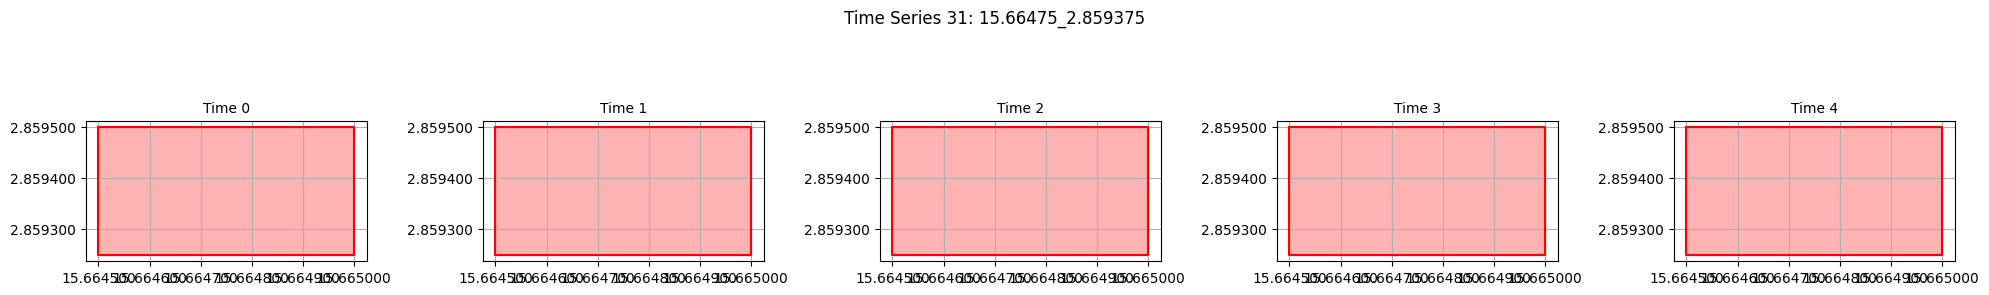

In [60]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.ticker as ticker
import pickle

def plot_raw_polygon(idx):
    df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/train.csv')
    row = df.iloc[idx]
    folder = row['example_path'].split('/')[1]
    shape_path = f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/{folder}/forest_loss_region.pkl'
    
    with open(shape_path, 'rb') as f:
        geom = pickle.load(f)

    fig, ax = plt.subplots(figsize=(10, 10))

    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.plot(x, y, color='red')
        ax.fill(x, y, color='red', alpha=0.3)
    elif geom.geom_type == 'MultiPolygon':
        for poly in geom:
            x, y = poly.exterior.xy
            ax.plot(x, y, color='red')
            ax.fill(x, y, color='red', alpha=0.3)
    else:
        print("Unsupported geometry type:", geom.geom_type)
        return

    ax.set_title("Raw Forest Loss Polygon (Lon/Lat)")
    ax.set_xlabel("Longitude")
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))
    ax.set_ylabel("Latitude")
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()

def plot_single_timeseries_polygons(series_idx, timestamps=5):
    """
    Visualize raw polygons for a single time series.
    
    Parameters:
    - series_idx: Index of the time series to display
    - timestamps: Number of timestamps to show (default 5)
    """
    df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/train.csv')
    
    # Extract base coordinates without timestamp
    df['series_id'] = df['example_path'].apply(lambda x: re.sub(r'_\d+$', '', x.split('/')[-1]))
    
    # Get unique series and select the requested one
    unique_series = df['series_id'].unique()
    selected_series = unique_series[series_idx]
    
    # Get all timestamps for this series, sorted
    series_df = df[df['series_id'] == selected_series] \
               .sort_values('example_path') \
               .head(timestamps)
    
    fig, axs = plt.subplots(1, timestamps, figsize=(20, 3))
    if timestamps == 1:
        axs = [axs]  # Ensure it's iterable
    
    for time_idx, (_, row) in enumerate(series_df.iterrows()):
        ax = axs[time_idx]
        folder = row['example_path'].split('/')[-1]
        shape_path = f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/{folder}/forest_loss_region.pkl'
        
        try:
            with open(shape_path, 'rb') as f:
                geom = pickle.load(f)

            if geom.geom_type == 'Polygon':
                x, y = geom.exterior.xy
                ax.plot(x, y, color='red')
                ax.fill(x, y, color='red', alpha=0.3)
            elif geom.geom_type == 'MultiPolygon':
                for poly in geom.geoms:
                    if not poly.is_empty:
                        x, y = poly.exterior.xy
                        ax.plot(x, y, color='red')
                        ax.fill(x, y, color='red', alpha=0.3)

            
            # Formatting
            ax.set_title(f"Time {time_idx}", fontsize=10)
            ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))
            ax.set_aspect('equal')
            ax.grid(True)
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {str(e)}", 
                    ha='center', va='center', fontsize=8)
            ax.set_title(f"Time {time_idx}", fontsize=10)
    
    plt.suptitle(f"Time Series {series_idx}: {selected_series}", y=1.05)
    plt.tight_layout()
    plt.show()

if 'Timeseries' in SUB_DIR:
    plot_single_timeseries_polygons(31)
else:
    plot_raw_polygon(494)

(1, 332, 332)


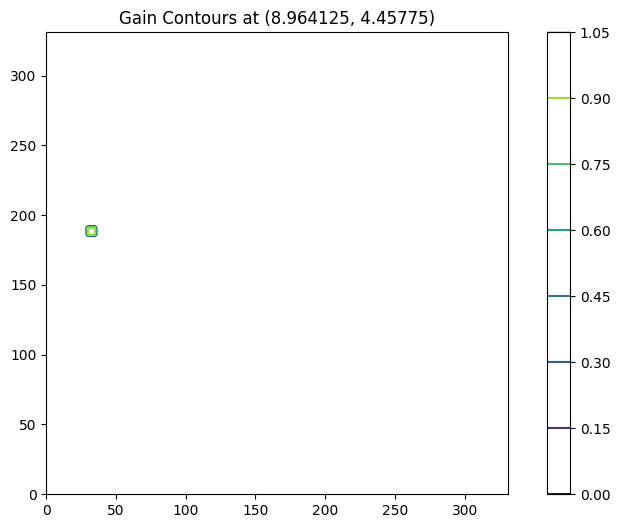

In [7]:
data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/{folder}/auxiliary/gain.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array[0], cmap = "viridis", 
            )
plt.title("Gain Contours at (8.964125, 4.45775)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

(332, 332)


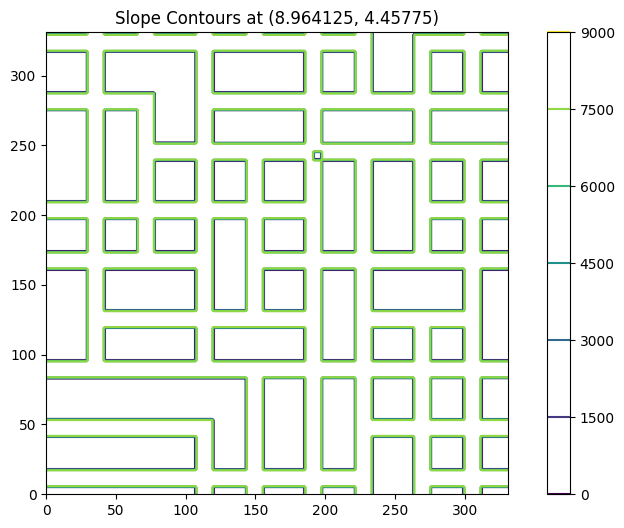

In [8]:
data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/{folder}/auxiliary/slope.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array, cmap = "viridis", 
            )
plt.title("Slope Contours at (8.964125, 4.45775)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

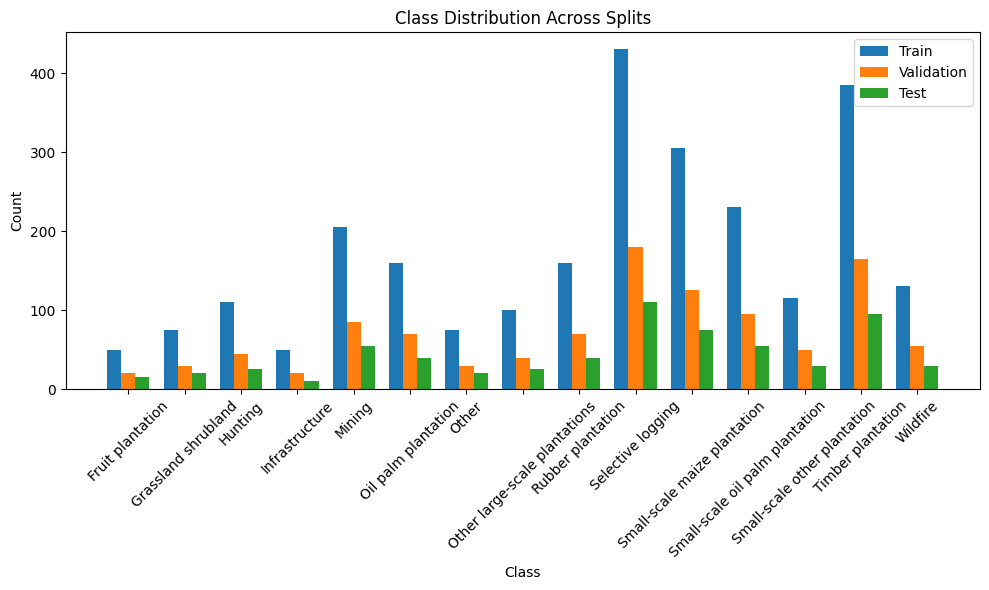

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(train, val, test):
    # Get all unique categories from all datasets
    all_categories = list(set(train['merged_label']) | 
                     set(val['merged_label']) | 
                     set(test['merged_label']))
    all_categories.sort()  # Sort alphabetically
    
    # Create positions for bars
    x = np.arange(len(all_categories))
    width = 0.25
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Function to get counts for each split
    def get_counts(df):
        counts = df['merged_label'].value_counts()
        return [counts.get(cat, 0) for cat in all_categories]
    
    # Plot bars for each split
    plt.bar(x - width, get_counts(train), width, label='Train')
    plt.bar(x, get_counts(val), width, label='Validation')
    plt.bar(x + width, get_counts(test), width, label='Test')
    
    # Add labels and formatting
    plt.xticks(x, all_categories, rotation=45)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution Across Splits')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage with your actual data:
plot_class_distribution(train_df, val_df, test_df)

In [ ]:
class ForestDataset(Dataset):
    """Forest dataset with unified time series support."""
    LABEL_SCHEMES = {
        'Grouped': {
            'Grassland shrubland': 0,
            'Other': 1,
            'Plantation': 2,
            'Smallholder agriculture': 3
        },
        'Detailed': {
            'Oil palm plantation': 0,
            'Timber plantation': 1,
            'Fruit plantation': 2,
            'Rubber plantation': 3,
            'Other large-scale plantations': 4,
            'Grassland shrubland': 5,
            'Small-scale oil palm plantation': 6,
            'Small-scale maize plantation': 7,
            'Small-scale other plantation': 8,
            'Mining': 9,
            'Selective logging': 10,
            'Infrastructure': 11,
            'Wildfire': 12,
            'Hunting': 13,
            'Other': 14
        },
        'Timeseries': {
            'Mining': 0,
            'Wildfire': 1,
            'Small-scale other plantation': 2,
            'Oil palm plantation': 3,
            'Small-scale oil palm plantation': 4,
            'Timber plantation': 5,
            'Rubber plantation': 6,
            'Hunting': 7,
            'Selective logging': 8,
            'Infrastructure': 9,
            'Other large-scale plantations': 10,
            'Fruit plantation': 11,
            'Small-scale maize plantation': 12,
            'Other': 13,
            'Grassland shrubland': 14
        }
    }

    def __init__(self, csv_file_to_df, root_dir='CAM-ForestNetDataset', 
                 sub_dir="Landsat-Detailed-Timeseries", transform=None, 
                 types="classifier", 
                 time_steps=1):
        """
        Args:
            time_steps: Number of time steps to load (1 for single image)
        """
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.sub_dir = sub_dir
        self.transform = transform
        self.time_steps = time_steps if time_steps else TIMESERIES_LENGTH
        self.types = types
        self.label_to_int = self.LABEL_SCHEMES[LABEL_SCHEME]

    def __len__(self):
        return len(self.csv)

    def _poly_from_utm(self, polygon):
        poly_pts = []
        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):
            poly_pts.append(tuple(i))
        return Polygon(poly_pts)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        merged_label = self.csv.iloc[idx, 1]
        folder = self.csv.iloc[idx, 5]
        
        base_folder = os.path.join(self.root_dir, self.sub_dir, folder)
        
        images, segs, slopes = [], [], []
        for t in range(self.time_steps):
            # Load image
            png_files = glob.glob(os.path.join(base_folder, 'images/visible/*.png'))
            if not png_files:
                raise FileNotFoundError(f"No PNG files found in {base_folder}/images/visible")
            image = io.imread(png_files[0])[..., :3]
        
            # Load slope
            slope = np.load(os.path.join(base_folder, 'auxiliary/slope.npy'))
            
            # Load and process polygon data
            with open(f'{base_folder}/forest_loss_region.pkl', 'rb') as f:
                data = pickle.load(f)
            
            # Create blank mask
            mask = Image.new('L', (332, 332), 0)
            draw = ImageDraw.Draw(mask)
            
            # Get centroid
            lon_c = data.centroid.xy[0][0]
            lat_c = data.centroid.xy[1][0]
            
            # Meters per degree approximation (consistent with visualization)
            m_per_deg_lat = 111132.954 - 559.822 * np.cos(2 * lat_c) + 1.175 * np.cos(4 * lat_c) - 0.0023 * np.cos(6 * lat_c)
            m_per_deg_lon = 111132.954 * np.cos(lat_c) - 93.5 * np.cos(3 * lat_c) + 0.118 * np.cos(5 * lat_c)
            
            # Calculate conversion factors (consistent with visualization)
            deg_lat = (332 * PIXEL_RESOLUTION * 0.5) / m_per_deg_lat
            deg_lon = (332 * PIXEL_RESOLUTION * 0.5) / m_per_deg_lon
            div_lon = 2 * deg_lon / 332
            div_lat = 2 * deg_lat / 332
            
            # Convert and draw polygons
            if data.geom_type == "Polygon":
                coords = []
                for lon, lat in data.exterior.coords:
                    x = 332 - int((lon - lon_c + deg_lon) / div_lon)
                    y = 332 - int((lat - lat_c + deg_lat) / div_lat)
                    coords.append((x, y))
                draw.polygon([tuple(coord) for coord in coords], fill=1)
            else:
                for poly in data:
                    coords = []
                    for lon, lat in data.exterior.coords:
                        x = 332 - int((lon - lon_c + deg_lon) / div_lon)
                        y = 332 - int((lat - lat_c + deg_lat) / div_lat)
                        coords.append((x, y))
                    draw.polygon([tuple(coord) for coord in coords], fill=1)
            
            seg = np.array(mask)
            
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented["image"]
            
            # Apply same cropping as visualization (160x160 center crop)
            images.append(torch.from_numpy(image).float().permute(2,0,1)[:, 86:246, 86:246])
            segs.append(torch.from_numpy(seg).byte()[86:246, 86:246])
            slopes.append(torch.from_numpy(slope).float()[86:246, 86:246])
        
        image_series = torch.stack(images)
        seg_series = torch.stack(segs)
        slope_series = torch.stack(slopes)
        
        merged_label = self.label_to_int[merged_label]
        
        if self.types == "classifier":
            return image_series, seg_series, slope_series, merged_label
        return image_series, seg_series, merged_label

In [11]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(270),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03
        ),
    ]
)

In [12]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
EPOCHS = 20

In [13]:
train_dataset = ForestDataset( csv_file_to_df=train_df, transform=transform, root_dir=BASE_DIR, sub_dir=SUB_DIR, time_steps=TIMESERIES_LENGTH)
val_dataset = ForestDataset( csv_file_to_df=val_df, root_dir=BASE_DIR, sub_dir=SUB_DIR, time_steps=TIMESERIES_LENGTH)
test_dataset = ForestDataset( csv_file_to_df=test_df, root_dir=BASE_DIR, sub_dir=SUB_DIR, time_steps=TIMESERIES_LENGTH)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, transform=transform, root_dir=BASE_DIR, sub_dir=SUB_DIR, types="projection", time_steps=TIMESERIES_LENGTH)
val_dataset_re = ForestDataset( csv_file_to_df=val_df, root_dir=BASE_DIR, sub_dir=SUB_DIR, types="projection", time_steps=TIMESERIES_LENGTH)
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection", root_dir=BASE_DIR, sub_dir=SUB_DIR, time_steps=TIMESERIES_LENGTH)
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

images shape on PyTorch :  torch.Size([16, 5, 3, 160, 160])
seg shape on PyTorch :  torch.Size([16, 5, 160, 160])
slope shape on PyTorch :  torch.Size([16, 5, 160, 160])
labels shape on Pytorch :  torch.Size([16])


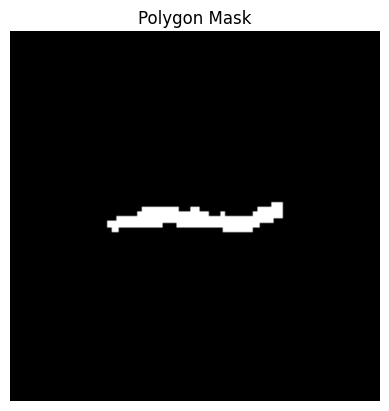

In [14]:
dataiter = iter(trainloader)
images, seg, slope, labels = next(dataiter)

print('images shape on PyTorch : ', images.size())
print('seg shape on PyTorch : ', seg.size())
print('slope shape on PyTorch : ', slope.size())
print('labels shape on Pytorch : ', labels.size())

plt.imshow(seg[0][0].numpy(), cmap='gray')
plt.title("Polygon Mask")
plt.axis('off')
plt.show()

In [15]:
sample = next(iter(trainloader_re))[1]
print(sample.shape)

sample_target = next(iter(valloader_re))[1]
print(sample_target.shape)

torch.Size([16, 5, 160, 160])
torch.Size([16, 5, 160, 160])


In [159]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [160]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}
NB_CLASSES = len(train_dataset.label_to_int)

In [161]:
criterion_class = FocalLoss()
criterion_seg = DiceLoss()

In [162]:
"""Training UNet Classifier + Segmentation"""

unet_model = UNet(3,NB_CLASSES,"classification")
unet_model = unet_model.to(device)

optimizer = torch.optim.AdamW(unet_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_seg_dict = {'train':[], 'val':[]}
acc_class_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

In [163]:
def train_model(model, optimizer, scheduler, dataloaders, criterion_seg, criterion_class,
                acc_seg_dict, acc_class_dict, loss_dict, device,
                num_epochs=25, patience=5,save_dir='model_weights', resume=False):
    
    os.makedirs(save_dir, exist_ok=True)

    def get_dynamic_filename(epoch=None, acc=None, suffix="pth"):
        date_str = datetime.now().strftime("%Y%m%d")
        name_parts = [str(x) for x in [MODEL_NAME, SUB_DIR]]
        if epoch is not None:
            name_parts.append(f"epoch{epoch}")
        if acc is not None:
            name_parts.append(f"acc{acc:.4f}")
        name_parts.append(date_str)
        return os.path.join(save_dir, "_".join(name_parts) + f".{suffix}")

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0
    start_epoch = 0

    checkpoint_path = get_dynamic_filename(suffix="checkpoint")

    # Resume if enabled
    if resume and os.path.exists(checkpoint_path):
        checkpoint = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
        best_acc = checkpoint['best_acc']
        start_epoch = checkpoint['epoch'] + 1
        epochs_without_improvement = checkpoint.get('epochs_without_improvement', 0)
        best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(start_epoch, num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_acc_seg = 0.0
            running_acc_class = 0.0

            for images, seg, slope, labels in dataloaders[phase]:
                if images.ndim == 5 and images.shape[1] == 1:
                    images = images.squeeze(1)
                if seg.ndim == 4 and seg.shape[1] > 1:
                    seg = seg.unsqueeze(2)

                images, seg, slope, labels = images.to(device), seg.to(device), slope.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, out_class = model(images, slope)
                    loss_seg = criterion_seg(outputs, seg.float())
                    loss_class = criterion_class(out_class, labels)
                    loss = loss_seg + loss_class

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                m1, m0, m_avg = get_acc_binseg(outputs, seg.float())
                running_acc_seg += m_avg
                running_acc_class += get_acc_class(out_class, labels).item()
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc_seg = running_acc_seg / len(dataloaders[phase])
            epoch_acc_class = running_acc_class / len(dataloaders[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc Seg: {epoch_acc_seg:.4f} Acc Class: {epoch_acc_class:.4f}')
            acc_seg_dict[phase].append(epoch_acc_seg)
            acc_class_dict[phase].append(epoch_acc_class)
            loss_dict[phase].append(epoch_loss)

            # Save checkpoint if best
            if phase == 'val':
                if epoch_acc_class > best_acc:
                    best_acc = epoch_acc_class
                    best_model_wts = copy.deepcopy(model.state_dict())
                    save_checkpoint({
                        'epoch': epoch,
                        'model_state_dict': best_model_wts,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_acc': best_acc,
                        'epochs_without_improvement': 0,
                    }, checkpoint_path)
                    epochs_without_improvement = 0
                    print(f"New best model saved at epoch {epoch+1}")
                else:
                    epochs_without_improvement += 1
                    print(f"No improvement. Patience counter: {epochs_without_improvement}/{patience}")

                if epochs_without_improvement >= patience:
                    print("Early stopping triggered.")
                    model.load_state_dict(best_model_wts)
                    final_path = get_dynamic_filename(epoch=epoch, acc=best_acc)
                    torch.save(model.state_dict(), final_path)
                    print(f"Final model saved to {final_path}")
                    return model

    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    final_path = get_dynamic_filename(epoch=num_epochs, acc=best_acc)
    torch.save(model.state_dict(), final_path)
    print(f"Final model saved to {final_path}")
    return model

In [ ]:
unet_classifier_segmentation = train_model(
    unet_model,
    optimizer,
    scheduler,
    num_epochs=EPOCHS,
    dataloaders=dataloaders,
    criterion_seg=criterion_seg,
    criterion_class=criterion_class,
    acc_class_dict=acc_class_dict,
    acc_seg_dict=acc_seg_dict,
    loss_dict=loss_dict,
    device="cpu"
)

In [165]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

<Figure size 2200x800 with 0 Axes>

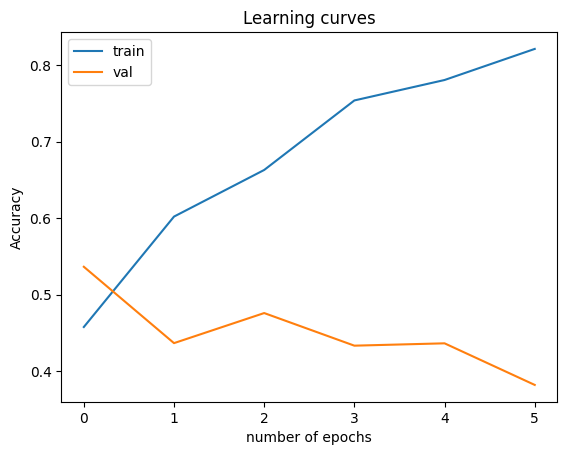

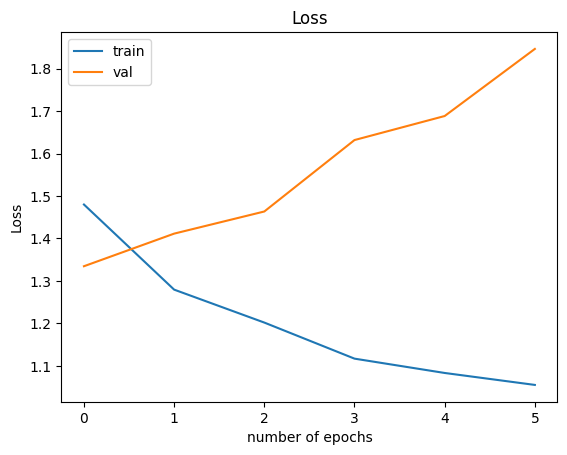

In [166]:
show_curves(acc_class_dict, loss_dict)

<Figure size 2200x800 with 0 Axes>

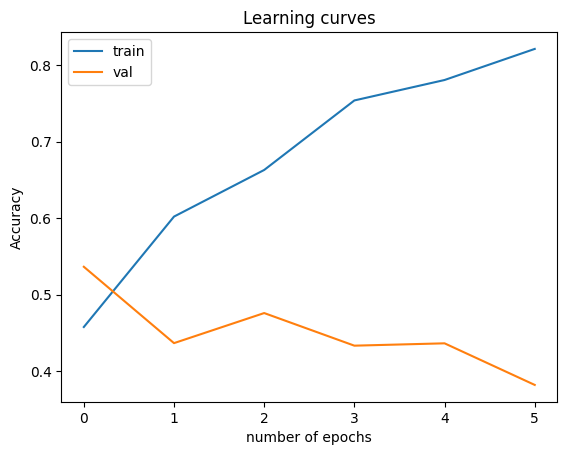

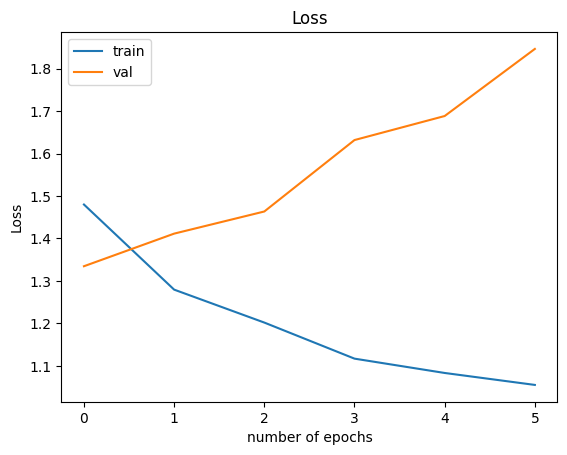

In [167]:
show_curves(acc_class_dict, loss_dict)

In [168]:
def test(model, dataloader, dataset):
    model.eval()

    all_preds = []
    all_labels = []
    class_names = [label for label, _ in sorted(dataset.label_to_int.items(), key=lambda x: x[1])]

    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for images, seg, slope, labels in dataloader: 
            if images.ndim == 5 and images.shape[1] == 1:
                images = images.squeeze(1)
            if seg.ndim == 4 and seg.shape[1] > 1:
                seg = seg.unsqueeze(2)
                
            images = images.to(device)
            seg = seg.to(device)
            slope = slope.to(device)
            labels = labels.to(device)

            outputs, out_class = model(images, slope)

            total += labels.size(0) 
            running_accuracy += get_acc_class(out_class, labels).item()
            preds = torch.argmax(out_class, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy()) 
 
        print('Accuracy of the model based on the test set is: %d %%' % (100 * running_accuracy / len(testloader))) 

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
 

In [169]:
test(unet_classifier_segmentation, testloader, test_dataset)

Accuracy of the model based on the test set is: 55 %

Classification Report:
                         precision    recall  f1-score   support

    Grassland shrubland       0.00      0.00      0.00        15
                  Other       0.52      0.51      0.51       180
             Plantation       0.58      0.58      0.58       151
Smallholder agriculture       0.58      0.69      0.63       120

               accuracy                           0.56       466
              macro avg       0.42      0.44      0.43       466
           weighted avg       0.54      0.56      0.55       466


Confusion Matrix:
[[ 0 13  1  1]
 [ 0 91 46 43]
 [ 0 48 87 16]
 [ 0 22 15 83]]


In [170]:
def plot_prediction_comparison(model, dataloader, num_examples=3):
    model.eval()
    fig, axes = plt.subplots(num_examples, 4, figsize=(20, 5*num_examples))
    
    with torch.no_grad():
        for i, (images, seg, slope, labels) in enumerate(dataloader):
            if i >= num_examples:
                break

            # Handle input dimensions
            if images.ndim == 5 and images.shape[1] == 1:
                images = images.squeeze(1)
                
            images = images.to(device)
            seg = seg.to(device)
            slope = slope.to(device)
            
            # Get predictions
            outputs, out_class = model(images, slope)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            pred_class = torch.argmax(out_class, dim=1)
            true_class = labels[i]
            
            # Process image for display
            img_np = images[0].cpu().permute(1,2,0).numpy()
            img_np = img_np.astype(np.float32)
            for c in range(3):
                channel = img_np[:, :, c]
                img_np[:, :, c] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-5)

            # Process masks - fix reshaping here
            true_mask = seg[0].cpu().squeeze().numpy()  # Remove channel dim if present
            pred_mask = pred_masks[0].cpu().squeeze().numpy()
            
            # Calculate IoU
            iou = jaccard_score(true_mask.flatten(), pred_mask.flatten(), average='binary')
            
            # Plotting
            axes[i,0].imshow(img_np)
            axes[i,0].set_title('Input Image')
            axes[i,0].axis('off')
            
            axes[i,1].imshow(true_mask, cmap='gray')
            axes[i,1].set_title(f'Ground Truth\nClass: {labels[0].item()}')
            axes[i,1].axis('off')
            
            axes[i,2].imshow(pred_mask, cmap='gray')
            axes[i,2].set_title(f'Predicted Mask\nIoU: {iou:.3f}')
            axes[i,2].axis('off')
            
            # Class probabilities
            class_probs = torch.softmax(out_class[0], dim=0).cpu().numpy()
            num_classes = class_probs.shape[0]
            axes[i,3].bar(range(num_classes), class_probs)
            pred_class = torch.argmax(out_class[0]).item()
            axes[i,3].set_title(f'Class Probabilities\nPred: {pred_class} True: {true_class}')
            axes[i,3].set_ylim(0, 1)
            axes[i,3].set_xticks(range(num_classes))
    
    plt.tight_layout()
    plt.show()

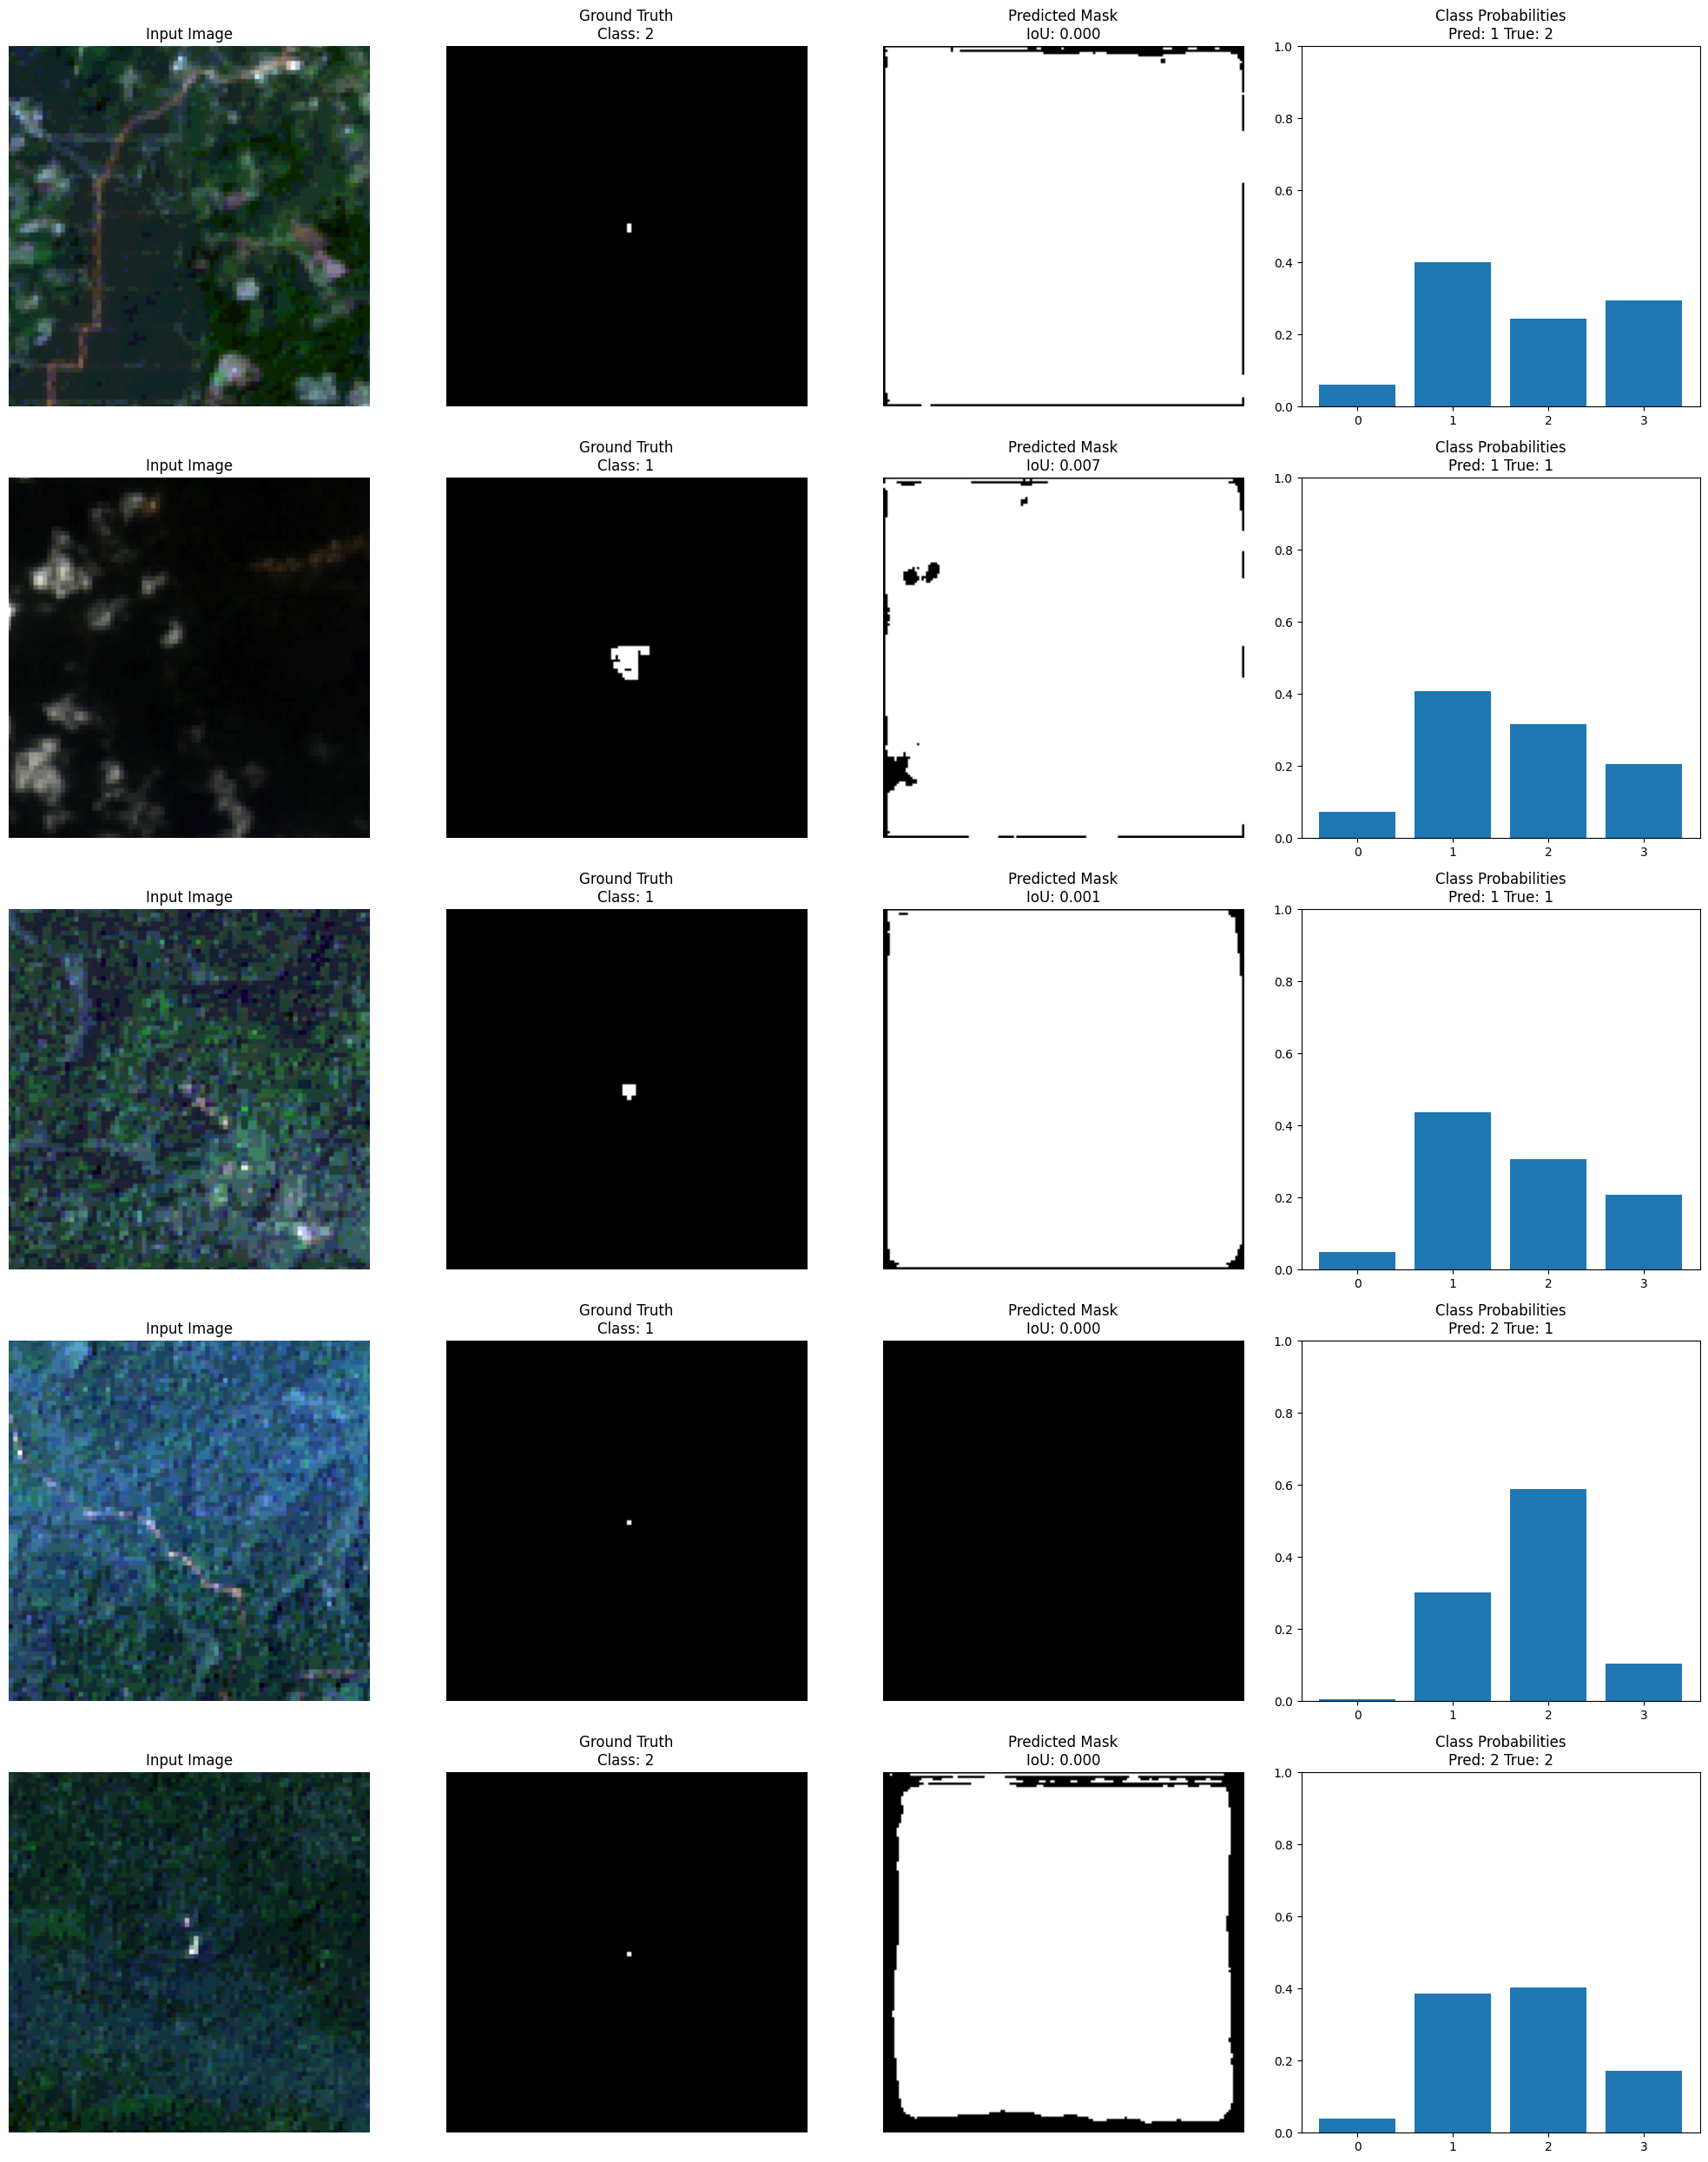

In [171]:
plot_prediction_comparison(unet_classifier_segmentation, testloader, num_examples=5)